# Chapter 2: Temporal Evolution of Credit Risk Relationships

In [1]:
import sys
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lightgbm as lgb
from sklearn.model_selection import train_test_split

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

from credit_risk_xai.config import (
    FEATURE_CACHE_PATH, ACTIVE_MODEL_VERSION, ACTIVE_FEATURES, get_display_name, FEATURE_BOUNDS
)
from credit_risk_xai.features.engineer import prepare_modeling_data
from credit_risk_xai.modeling.train import DEFAULT_PARAMS
from credit_risk_xai.modeling import compute_ale_for_feature, compute_ale_binary, compute_ece
from credit_risk_xai.plotting import (
    set_thesis_style, COLORS, FIGSIZE, save_figure, despine,
)
from src.xai_utils import calculate_shap_importance, compute_performance_metrics

# Initialize thesis-quality plotting style
set_thesis_style(use_tex=True)

FIGURES_DIR = PROJ_ROOT / "figures"

TEMPORAL_FEATURES = [f for f in ACTIVE_FEATURES if f != 'term_spread']

# =============================================================================
# CONFIGURATION: Set to True to include industry code, False to exclude
# =============================================================================
INCLUDE_INDUSTRY_CODE = False  # Toggle this to include/exclude sni_group_3digit

if not INCLUDE_INDUSTRY_CODE:
    TEMPORAL_FEATURES = [f for f in TEMPORAL_FEATURES if f != 'sni_group_3digit']

print(f"Model version: {ACTIVE_MODEL_VERSION}")
print(f"Features for temporal analysis: {len(TEMPORAL_FEATURES)}")
if not INCLUDE_INDUSTRY_CODE:
    print("  (sni_group_3digit excluded - set INCLUDE_INDUSTRY_CODE=True to include)")

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model version: v2
Features for temporal analysis: 20
  (sni_group_3digit excluded - set INCLUDE_INDUSTRY_CODE=True to include)


## 1. Define Economic Periods (Single-Year Training)

We analyze 6 distinct economic periods. For each period, we train on **exactly one year** and test on the **next year**. Since the target variable is *next-year default*, the training year contains features predicting defaults in the test year, providing a clean temporal separation.

| Period | Train Year | Test Year | Economic Context |
|--------|------------|-----------|------------------|
| Pre-Crisis | 2005 | 2006 | Stable pre-crisis conditions |
| Financial Crisis | 2008 | 2009 | Peak of Global Financial Crisis |
| Sovereign Debt | 2011 | 2012 | European sovereign debt crisis |
| Recovery | 2015 | 2016 | Post-crisis recovery period |
| COVID | 2019 | 2020 | Pre-COVID features predicting COVID-era defaults |
| Post-COVID | 2021 | 2022 | Post-pandemic normalization/inflation shock |

In [2]:
# Single-year training approach: (train_year, test_year)
PERIODS = {
    'pre_crisis': (2005, 2006),
    'financial_crisis': (2008, 2009),
    'sovereign_debt': (2011, 2012),
    'recovery': (2015, 2016),
    'covid': (2019, 2020),
    'post_covid': (2021, 2022)
}

## 2. Load Data and Create Period-Specific Datasets

In [3]:
df = pd.read_parquet(FEATURE_CACHE_PATH)
df = df[
    (df["ser_aktiv"] == 1) & 
    (df["sme_category"].isin(["Small", "Medium"])) & 
    (df["knc_kncfall"] == 1) &
    (df["bransch_borsbransch_konv"] != "40.0")
]

In [4]:
# First, let's understand the data availability
print("Available years in dataset:", sorted(df['ser_year'].unique()))
print()

# Check target availability by year
target_by_year = df.groupby('ser_year').agg({
    'target_next_year': ['count', lambda x: x.notna().sum()]
}).round(0)
target_by_year.columns = ['total_rows', 'valid_targets']
print("Target availability by year:")
print(target_by_year)
print()

period_data = {}

for period_name, (train_year, test_year) in PERIODS.items():
    # Train on exactly one year, test on the next year
    train_mask = df['ser_year'] == train_year
    eval_mask = df['ser_year'] == test_year
    
    df_train_period = df[train_mask].copy()
    df_eval_period = df[eval_mask].copy()
    
    # Check how many have valid targets (this is what prepare_modeling_data will filter to)
    n_train_valid = df_train_period['target_next_year'].notna().sum()
    n_eval_valid = df_eval_period['target_next_year'].notna().sum()
    
    if n_train_valid == 0 or n_eval_valid == 0:
        print(f"SKIPPING {period_name}: Train {train_year} has {n_train_valid} valid targets, "
              f"Test {test_year} has {n_eval_valid} valid targets")
        continue
    
    # Use TEMPORAL_FEATURES (excludes sni_group_3digit)
    X_train, y_train = prepare_modeling_data(df_train_period, features=TEMPORAL_FEATURES)
    X_eval, y_eval = prepare_modeling_data(df_eval_period, features=TEMPORAL_FEATURES)
    
    # Double-check we have data after prepare_modeling_data
    if len(X_train) == 0 or len(X_eval) == 0:
        print(f"SKIPPING {period_name}: After filtering - Train has {len(X_train)} rows, "
              f"Test has {len(X_eval)} rows")
        continue
    
    period_data[period_name] = {
        'X_train': X_train, 'y_train': y_train,
        'X_eval': X_eval, 'y_eval': y_eval,
        'train_year': train_year,
        'eval_year': test_year
    }
    
    print(f"{period_name}: Train on {train_year} (n={len(X_train):,}, default rate={y_train.mean():.2%}) -> "
          f"Test on {test_year} (n={len(X_eval):,}, default rate={y_eval.mean():.2%})")

print(f"\nSuccessfully created {len(period_data)} periods: {list(period_data.keys())}")

Available years in dataset: [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

Target availability by year:
          total_rows  valid_targets
ser_year                           
1998           10467          10467
1999           10974          10974
2000           11293          11293
2001           11450          11450
2002           11411          11411
2003           11086          11086
2004           10915          10915
2005           11021          11021
2006           11531          11531
2007           12374          12374
2008           12359          12359
2009           11841          11841
2010           12026          12026
2011           12179          12179
2012           11986          11986
2013           11801          11801
2014           11704          11704
2015           12003          12003
2016           12422          12422
2017           12531         

## 3. Train Period-Specific Models

For each period, we train a LightGBM model on a single year and evaluate on the following year. This mimics a realistic deployment scenario where a model is trained on recent data and applied to predict near-future defaults.

In [5]:
period_models = {}
period_predictions = {}
period_shap = {}

for period_name, data in period_data.items():
    print(f"Training model for {period_name}...")
    X_train, y_train = data['X_train'], data['y_train']
    X_eval, y_eval = data['X_eval'], data['y_eval']
    
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
    
    model = lgb.LGBMClassifier(**DEFAULT_PARAMS)
    model.fit(
        X_tr, y_tr, 
        eval_set=[(X_val, y_val)], 
        eval_metric='logloss',
        categorical_feature='auto',
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(period=0)
        ]
    )
    
    y_pred_proba = model.predict_proba(X_eval)[:, 1]
    metrics = compute_performance_metrics(y_eval, y_pred_proba)
    
    sample_size = min(5000, len(X_eval))
    sample_idx = np.random.choice(len(X_eval), size=sample_size, replace=False) if sample_size < len(X_eval) else np.arange(len(X_eval))
    X_eval_sample = X_eval.iloc[sample_idx]
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_eval_sample)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    
    period_models[period_name] = model
    period_predictions[period_name] = {'y_true': y_eval, 'y_pred_proba': y_pred_proba, 'metrics': metrics}
    period_shap[period_name] = {'shap_values': shap_values, 'X_eval_sample': X_eval_sample, 'feature_names': X_eval.columns.tolist()}
    
    print(f"  -> AUC: {metrics['AUC']:.3f}, PR-AUC: {metrics['PR-AUC']:.3f}")

Training model for pre_crisis...


/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


  -> AUC: 0.888, PR-AUC: 0.094
Training model for financial_crisis...


/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


  -> AUC: 0.893, PR-AUC: 0.120
Training model for sovereign_debt...
  -> AUC: 0.886, PR-AUC: 0.158
Training model for recovery...


/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


  -> AUC: 0.882, PR-AUC: 0.113
Training model for covid...
  -> AUC: 0.883, PR-AUC: 0.120
Training model for post_covid...
  -> AUC: 0.888, PR-AUC: 0.102


/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


## 4. Feature Importance Stability Analysis

### 4.1 Calculate SHAP Importance for Each Period

In [6]:
importance_by_period = {}

for period_name, shap_data in period_shap.items():
    importance = calculate_shap_importance(
        shap_data['shap_values'],
        shap_data['feature_names']
    )
    importance_by_period[period_name] = importance.set_index('feature')['importance']

importance_evolution = pd.DataFrame(importance_by_period)
importance_evolution = importance_evolution.fillna(0)

# Use only periods that were successfully trained
available_periods = list(period_data.keys())
importance_evolution['mean'] = importance_evolution[available_periods].mean(axis=1)
importance_evolution['std'] = importance_evolution[available_periods].std(axis=1)
importance_evolution['cv'] = importance_evolution['std'] / importance_evolution['mean']
importance_evolution['cv'] = importance_evolution['cv'].replace([np.inf, -np.inf], np.nan)

importance_evolution = importance_evolution.sort_values('mean', ascending=False)
importance_evolution.head(20)

,pre_crisis,financial_crisis,sovereign_debt,recovery,covid,post_covid,mean,std,cv
feature,,,,,,,,,
ratio_cash_liquidity,0.187863,0.351286,0.295938,0.269481,0.236454,0.336973,0.279666,0.061769,0.220867
dividend_yield,0.358891,0.292302,0.262302,0.244636,0.006054,0.102180,0.211061,0.131217,0.621703
ny_skuldgrd,0.134783,0.160252,0.308711,0.162123,0.144903,0.212473,0.187207,0.065261,0.348605
ny_solid,0.112717,0.161430,0.244836,0.112684,0.156035,0.170743,0.159741,0.048589,0.304173
revenue_cagr_3y,0.094447,0.119659,0.156708,0.245843,0.050008,0.118925,0.130932,0.066363,0.506848
log_total_assets,0.190955,0.081576,0.084276,0.272922,0.060329,0.057269,0.124554,0.087800,0.704911
revenue_drawdown_5y,0.165430,0.100830,0.069658,0.212304,0.101442,0.082390,0.122009,0.055173,0.452205
ny_kapomsh,0.064999,0.136467,0.111040,0.052885,0.123680,0.176837,0.110984,0.046124,0.415594
interest_coverage,0.039014,0.150690,0.073446,0.151303,0.128603,0.113170,0.109371,0.044923,0.410743


### 4.2 Visualize Importance Evolution Heatmap

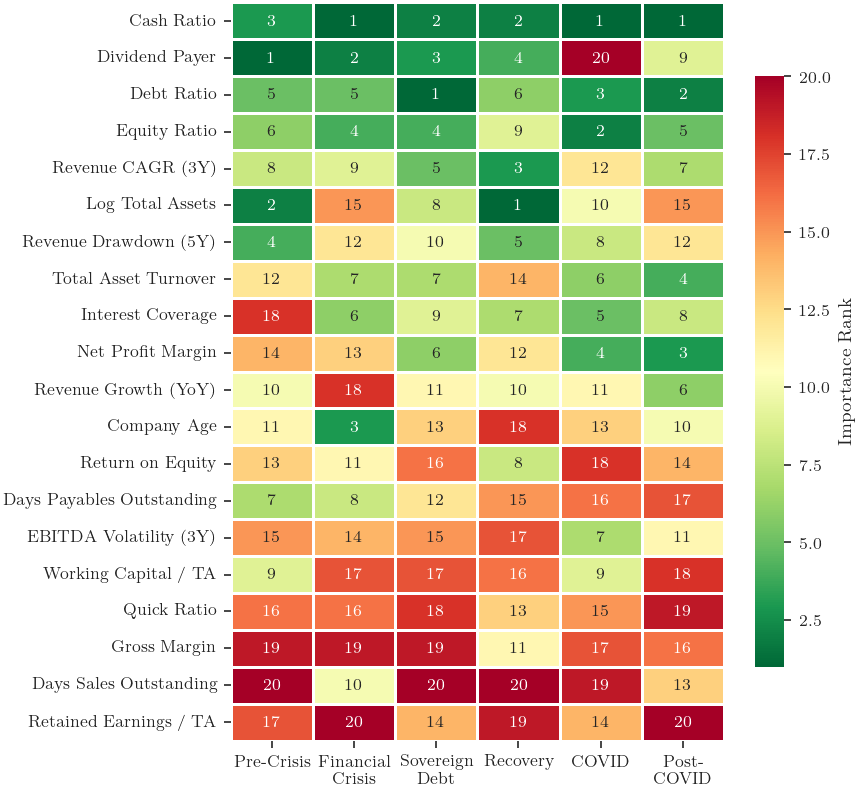

In [ ]:
# Feature Importance Rank Heatmap Over Time
fig, ax = plt.subplots(figsize=FIGSIZE['full_tall'])

top_features = importance_evolution.index.tolist()
available_periods = list(period_data.keys())

# Compute ranks for each period
rank_matrix = pd.DataFrame(index=top_features, columns=available_periods)
for period_name in available_periods:
    ranks = importance_evolution[period_name].rank(ascending=False)
    rank_matrix[period_name] = ranks[top_features]

# Human-readable feature names
display_labels = [get_display_name(f) for f in top_features]

# Clean period labels - updated for single-year training
period_display_names = {
    'pre_crisis': 'Pre-Crisis',
    'financial_crisis': 'Financial\nCrisis',
    'sovereign_debt': 'Sovereign\nDebt',
    'recovery': 'Recovery',
    'covid': 'COVID',
    'post_covid': 'Post-\nCOVID'
}

sns.heatmap(
    rank_matrix.astype(float),
    annot=True,
    fmt='.0f',
    annot_kws={'size': 8},
    cmap='RdYlGn_r',
    cbar_kws={'label': 'Importance Rank', 'shrink': 0.8},
    ax=ax,
    vmin=1,
    vmax=len(top_features),
    yticklabels=display_labels,
    linewidths=0.5,
    linecolor='white'
)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([period_display_names[p] for p in available_periods], rotation=0, ha='center')

plt.tight_layout()
save_figure(fig, FIGURES_DIR / 'temporal_importance_ranks_oneyear.pdf')
plt.show()

### 4.3 Performance Comparison Across Periods

In [8]:
available_periods = list(period_data.keys())

performance_comparison = pd.DataFrame({
    'Period': available_periods,
    'Train Year': [period_data[p]['train_year'] for p in available_periods],
    'Test Year': [period_data[p]['eval_year'] for p in available_periods],
    'AUC': [period_predictions[p]['metrics']['AUC'] for p in available_periods],
    'PR-AUC': [period_predictions[p]['metrics']['PR-AUC'] for p in available_periods],
    'Brier': [period_predictions[p]['metrics']['Brier Score'] for p in available_periods],
    'ECE': [period_predictions[p]['metrics']['ECE'] for p in available_periods],
    'Train Default Rate': [period_data[p]['y_train'].mean() for p in available_periods],
    'Test Default Rate': [period_predictions[p]['y_true'].mean() for p in available_periods]
})
performance_comparison

,Period,Train Year,Test Year,AUC,PR-AUC,Brier,ECE,Train Default Rate,Test Default Rate
0,pre_crisis,2005,2006,0.887799,0.093630,0.011471,0.007299,0.012884,0.011794
1,financial_crisis,2008,2009,0.892562,0.119876,0.015529,0.009907,0.024112,0.016553
2,sovereign_debt,2011,2012,0.886164,0.157853,0.017094,0.007604,0.018064,0.018855
3,recovery,2015,2016,0.881569,0.112878,0.016318,0.008743,0.014330,0.017389
4,covid,2019,2020,0.882949,0.119963,0.013441,0.008046,0.015258,0.014366
5,post_covid,2021,2022,0.888355,0.101601,0.010275,0.008586,0.019549,0.010663


## 5. ALE Plot Evolution (Threshold Shifts)

Investigate how risk relationships change across periods for key features.

In [9]:
top_features_for_ale = [
    f for f in importance_evolution.head(6).index.tolist()
    if period_data[list(PERIODS.keys())[0]]['X_eval'][f].dtype != 'category'
]

In [10]:
ale_evolution = {}
available_periods = list(period_data.keys())

all_features = [f for f in period_data[available_periods[0]]['X_eval'].columns 
                if period_data[available_periods[0]]['X_eval'][f].dtype != 'category']

binary_features = [f for f in all_features if FEATURE_BOUNDS.get(f) is None]
continuous_features = [f for f in all_features if FEATURE_BOUNDS.get(f) is not None]

for i, feature in enumerate(binary_features):
    print(f"Computing ALE for binary feature: {i+1}/{len(binary_features)} {feature}")
    ale_evolution[feature] = {'is_binary': True}
    
    for period_name in available_periods:
        model = period_models[period_name]
        X_eval = period_data[period_name]['X_eval']
        
        try:
            grid, ale, bounds = compute_ale_binary(model.predict_proba, X_eval, feature)
            ale_evolution[feature][period_name] = {'grid': grid, 'ale': ale, 'bounds': bounds}
        except:
            continue

for i, feature in enumerate(continuous_features):
    print(f"Computing ALE for continuous feature: {i+1}/{len(continuous_features)} {feature}")
    ale_evolution[feature] = {}
    bounds = FEATURE_BOUNDS.get(feature)
    
    for period_name in available_periods:
        model = period_models[period_name]
        X_eval = period_data[period_name]['X_eval']
        
        try:
            grid, ale, bounds_used = compute_ale_for_feature(model.predict_proba, X_eval, feature, feature_bounds=bounds)
            ale_evolution[feature][period_name] = {'grid': grid, 'ale': ale, 'bounds': bounds_used}
        except:
            continue

Computing ALE for binary feature: 1/1 dividend_yield
Computing ALE for continuous feature: 1/19 company_age
Computing ALE for continuous feature: 2/19 ny_kapomsh
Computing ALE for continuous feature: 3/19 ny_skuldgrd
Computing ALE for continuous feature: 4/19 ny_solid
Computing ALE for continuous feature: 5/19 ny_avkegkap
Computing ALE for continuous feature: 6/19 ny_kasslikv
Computing ALE for continuous feature: 7/19 ny_nettomarg
Computing ALE for continuous feature: 8/19 ny_omsf
Computing ALE for continuous feature: 9/19 log_total_assets
Computing ALE for continuous feature: 10/19 working_capital_ta
Computing ALE for continuous feature: 11/19 retained_earnings_ta
Computing ALE for continuous feature: 12/19 interest_coverage
Computing ALE for continuous feature: 13/19 ratio_cash_liquidity
Computing ALE for continuous feature: 14/19 gross_margin
Computing ALE for continuous feature: 15/19 dso_days
Computing ALE for continuous feature: 16/19 dpo_days
Computing ALE for continuous feature

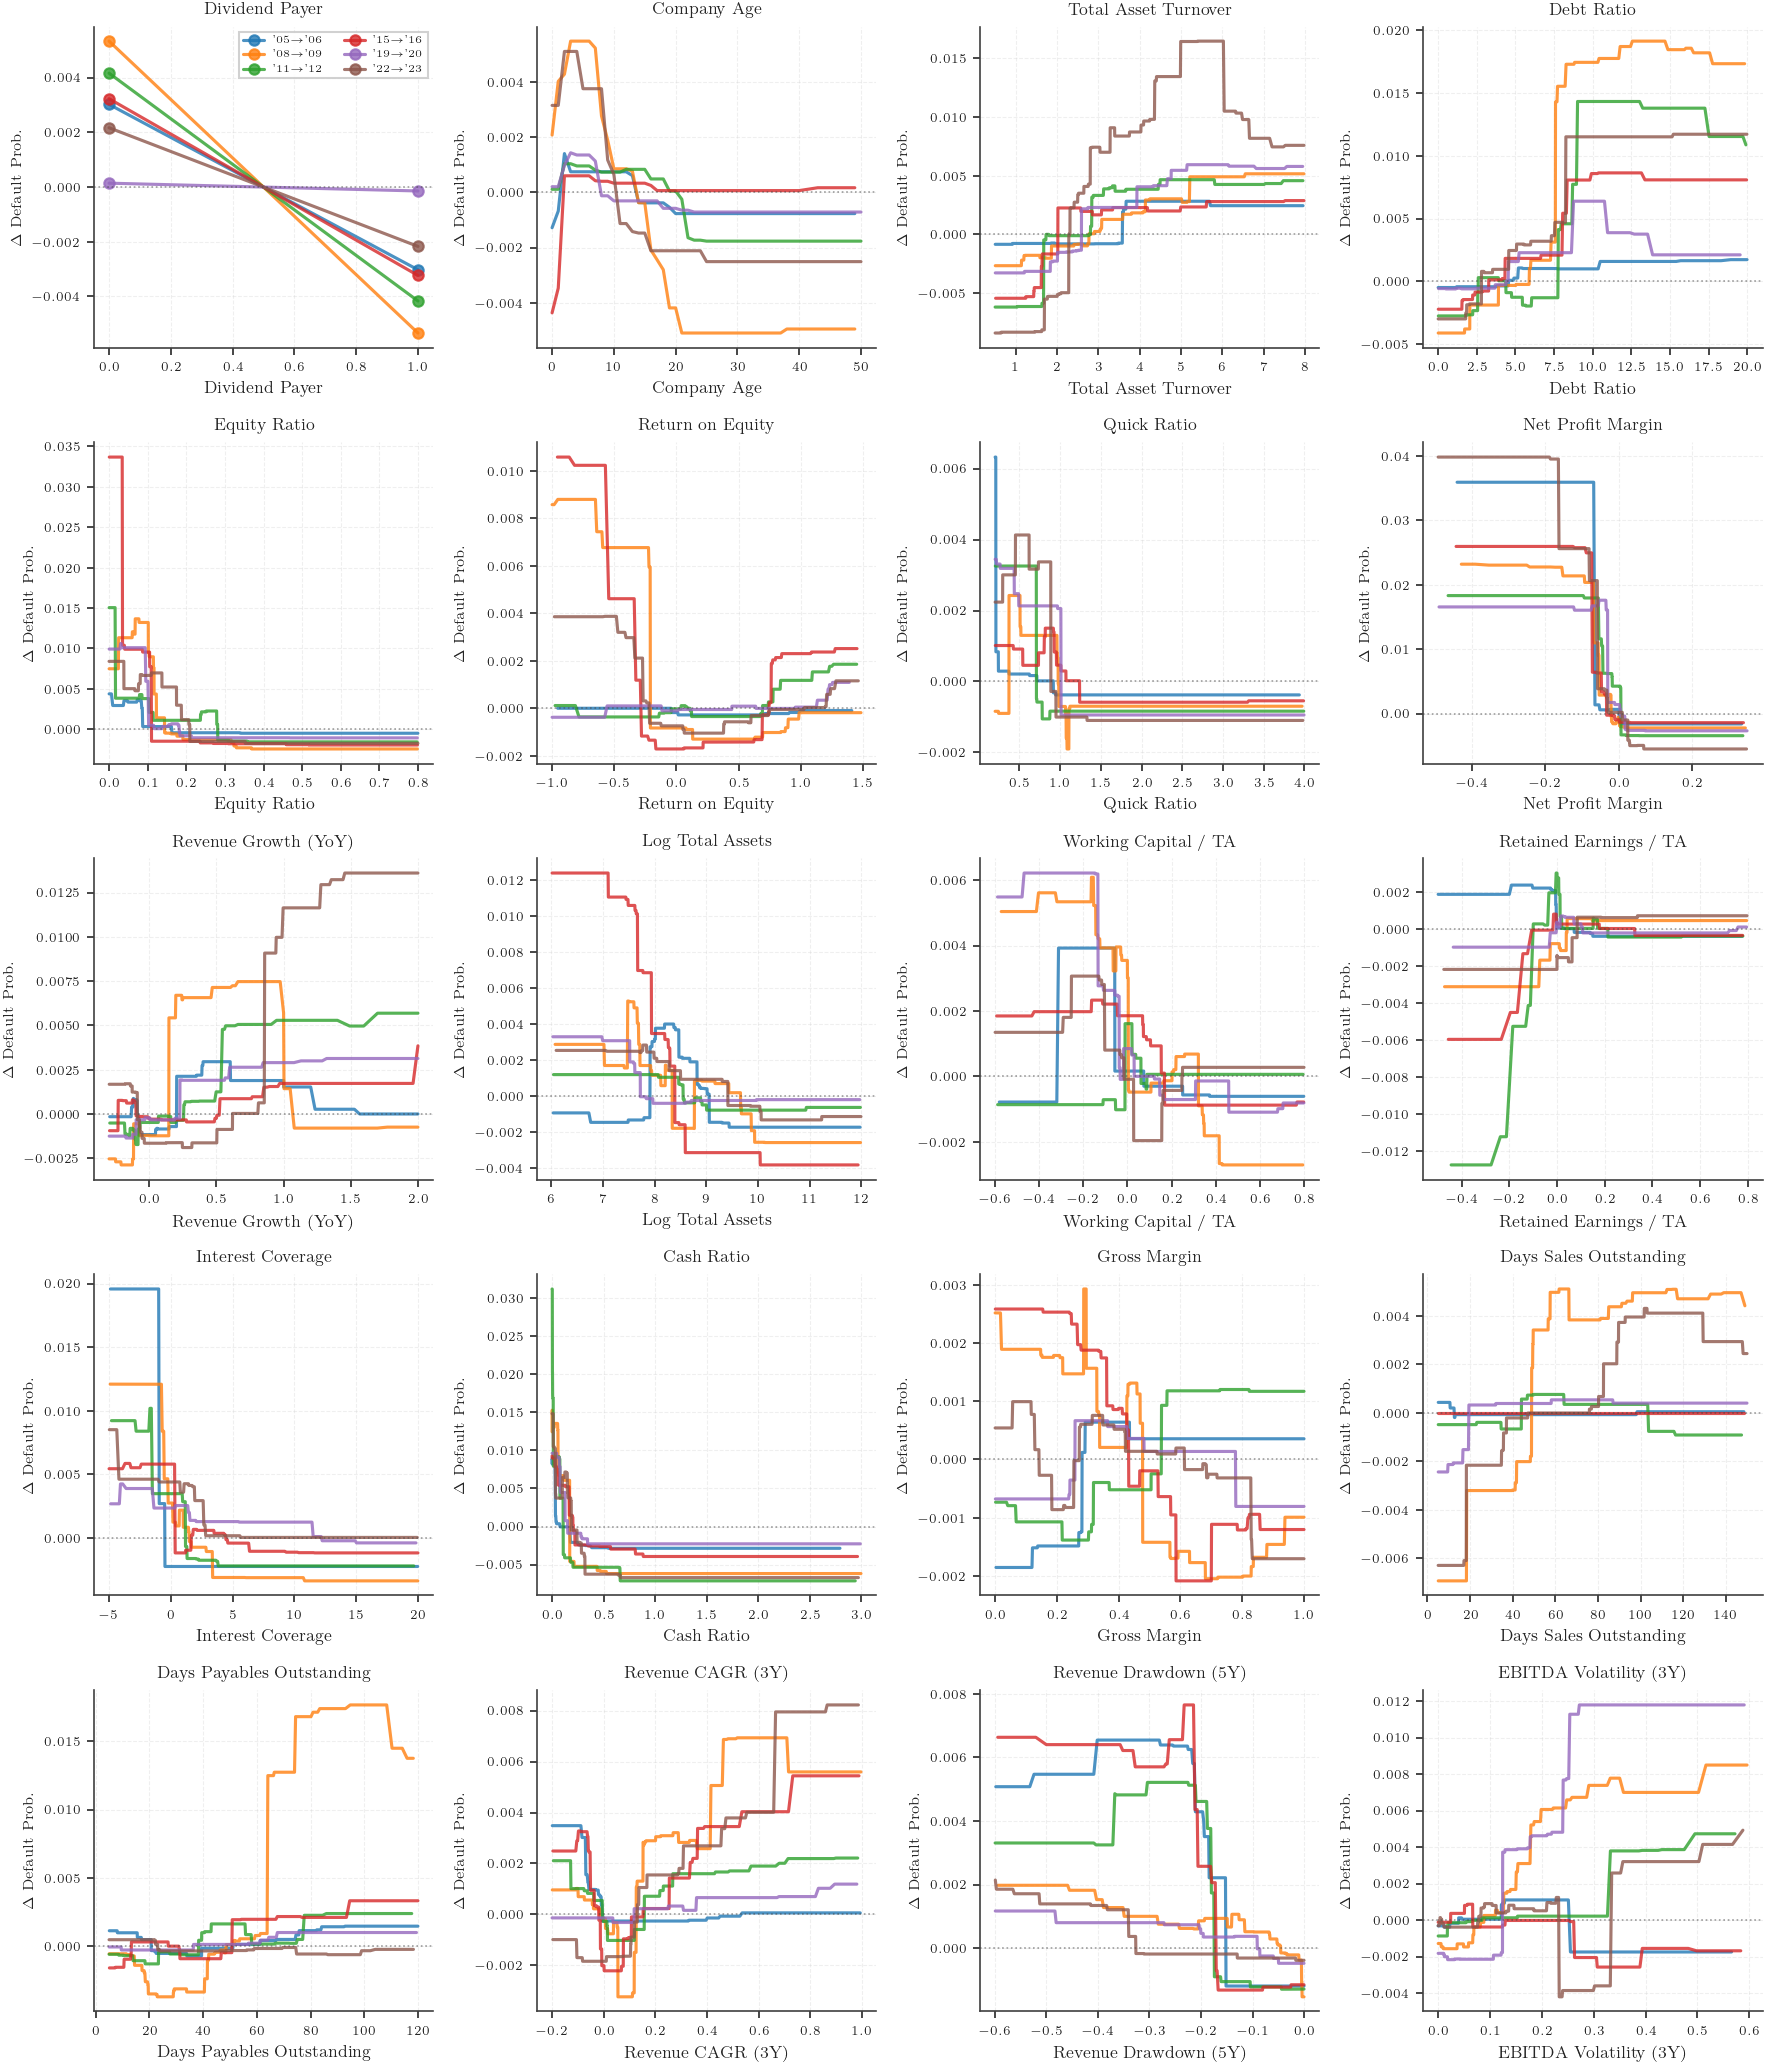

In [ ]:
# ALE Evolution Grid - All Features Across Economic Periods
n_features = len(ale_evolution)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols
available_periods = list(period_data.keys())

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2.8 * n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

# Period colors and labels
period_colors = {
    'pre_crisis': '#1f77b4',
    'financial_crisis': '#ff7f0e',
    'sovereign_debt': '#2ca02c',
    'recovery': '#d62728',
    'covid': '#9467bd',
    'post_covid': '#8c564b'
}
period_labels = {
    'pre_crisis': "'05$\\to$'06",
    'financial_crisis': "'08$\\to$'09",
    'sovereign_debt': "'11$\\to$'12",
    'recovery': "'15$\\to$'16",
    'covid': "'19$\\to$'20",
    'post_covid': "'22$\\to$'23"
}

for idx, (feature, feature_data) in enumerate(ale_evolution.items()):
    ax = axes[idx]
    display_name = get_display_name(feature)
    is_binary_feature = feature_data.get('is_binary', False)
    plotted_any = False
    
    for period_name in available_periods:
        if period_name not in feature_data:
            continue
            
        ale_data = feature_data[period_name]
        
        if 'grid' not in ale_data or 'ale' not in ale_data:
            continue
            
        if len(ale_data['grid']) > 0 and len(ale_data['ale']) > 0:
            is_binary = is_binary_feature or len(ale_data['grid']) <= 3
            
            ax.plot(
                ale_data['grid'],
                ale_data['ale'],
                label=period_labels[period_name],
                linewidth=1.5,
                color=period_colors[period_name],
                marker='o' if is_binary else None,
                markersize=5,
                alpha=0.8
            )
            plotted_any = True
    
    if plotted_any:
        ax.axhline(y=0, color=COLORS['neutral'], linestyle=':', linewidth=0.8, alpha=0.5)
        ax.set_xlabel(display_name, fontsize=8)
        ax.set_ylabel(r'$\Delta$ Default Prob.', fontsize=7)
        ax.set_title(display_name, fontsize=8, fontweight='bold')
        ax.tick_params(labelsize=6)
        despine(ax)
        
        if idx == 0:
            ax.legend(fontsize=5, loc='best', ncol=2)
    else:
        ax.text(0.5, 0.5, f'{display_name}\n(No variation)', 
                ha='center', va='center', transform=ax.transAxes, fontsize=8)
        ax.set_title(display_name, fontsize=8, fontweight='bold')

for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
save_figure(fig, FIGURES_DIR / 'ale_temporal_evolution_oneyear.pdf')
plt.show()

## 6. Feature Importance Evolution Over Time

Visualize how SHAP importance changes across economic periods for all features.

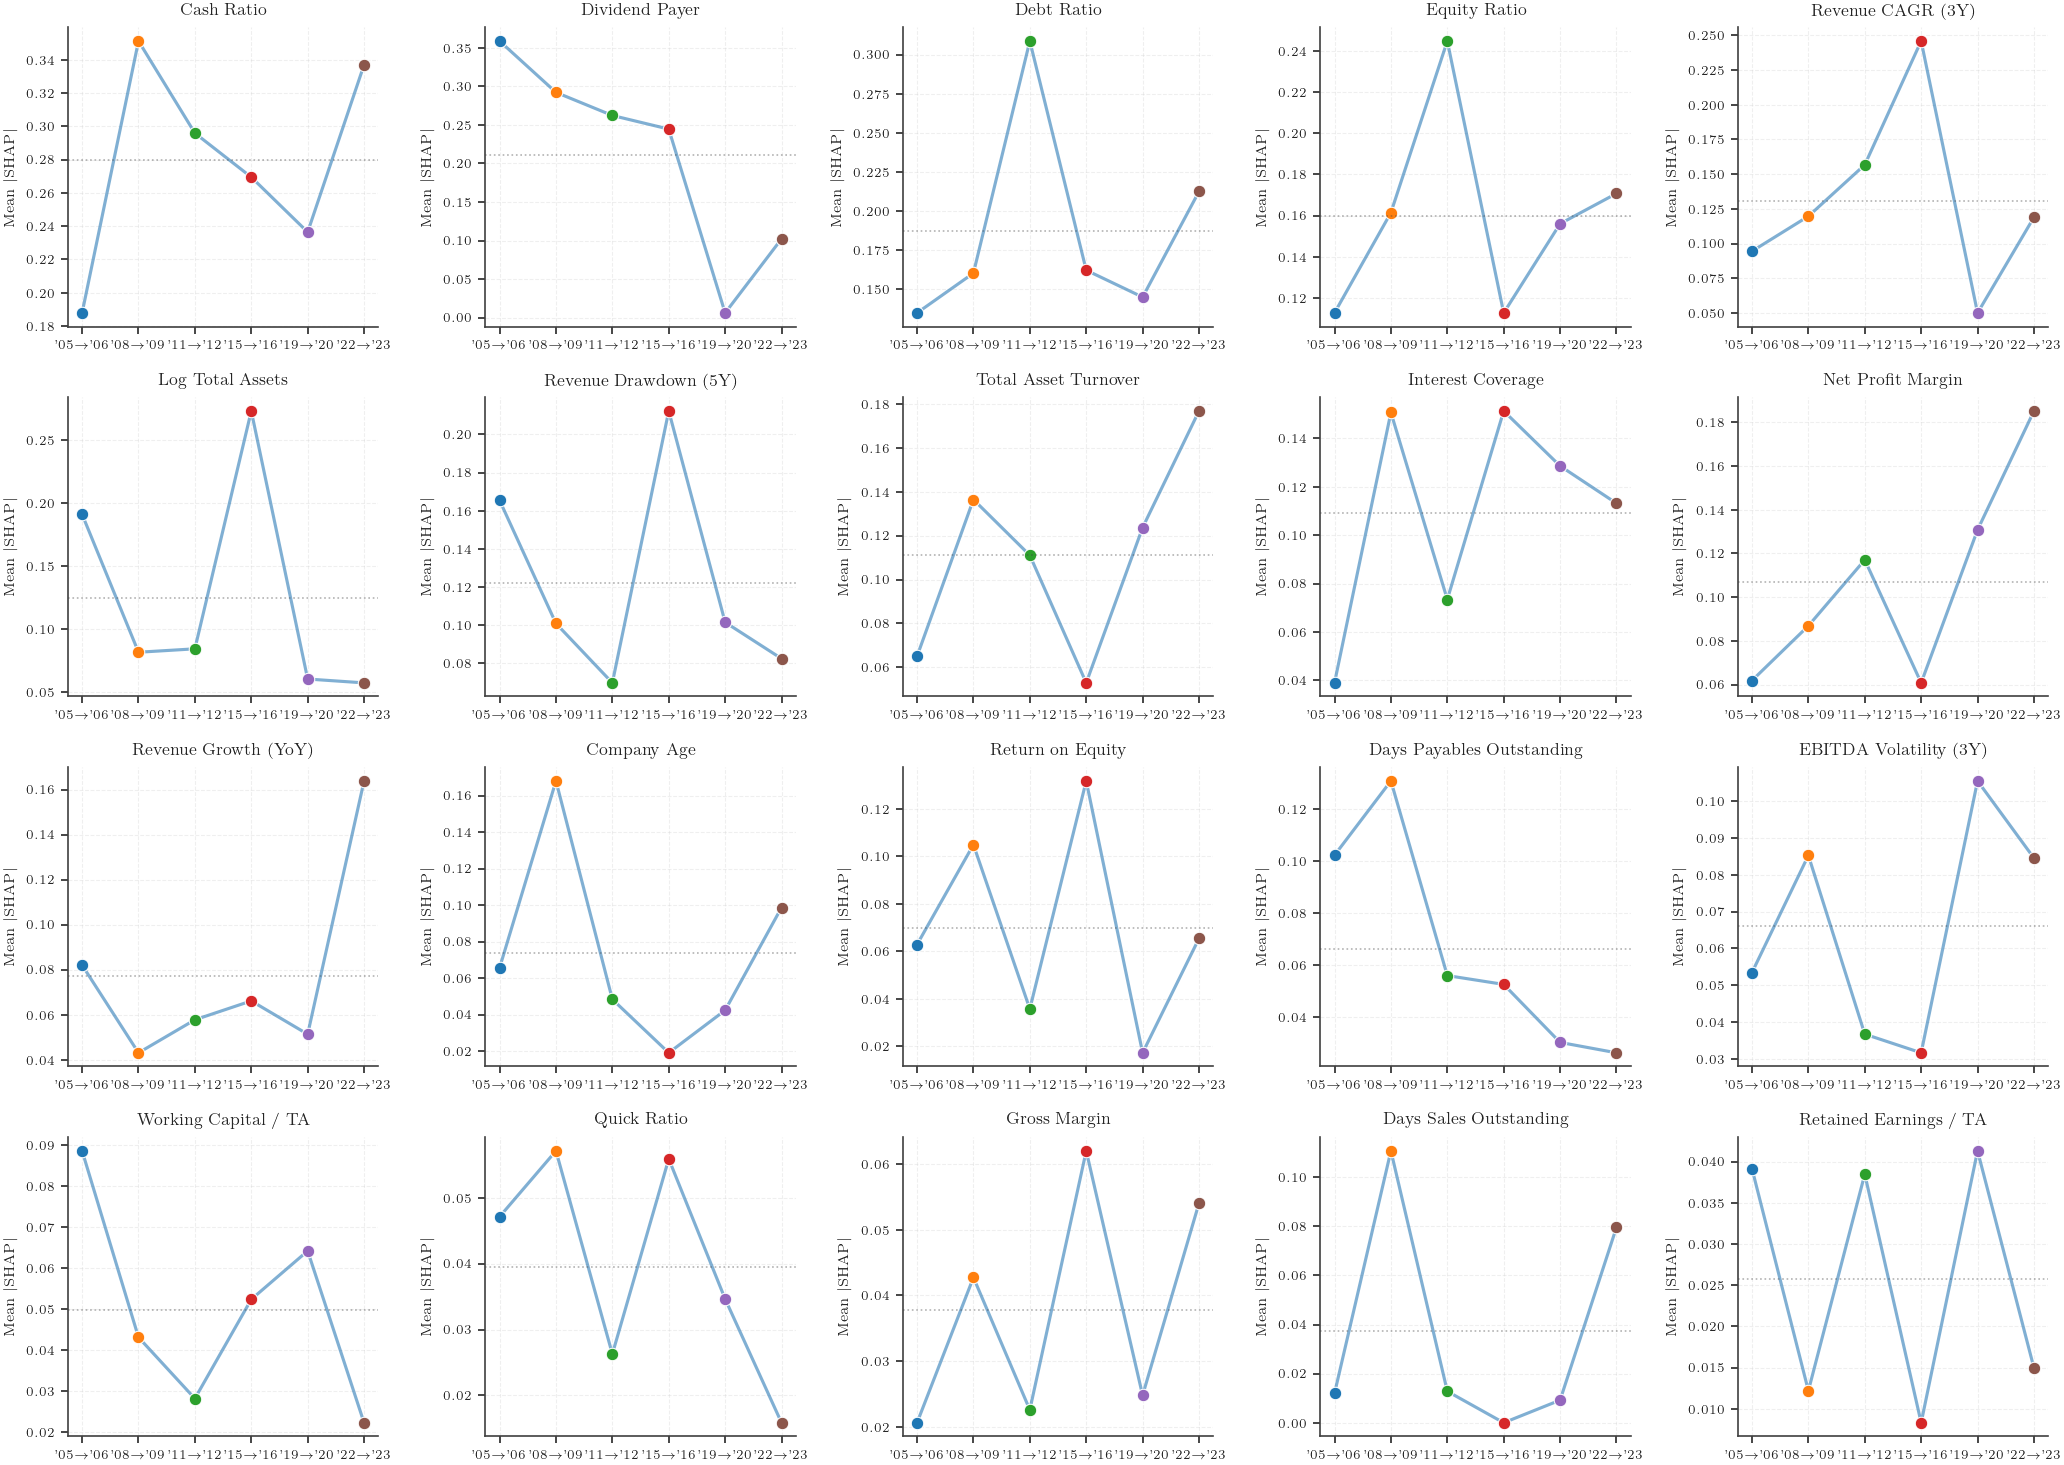

In [12]:
# Individual Feature Importance Evolution Over Time
n_features = len(importance_evolution)
n_cols = 5
n_rows = (n_features + n_cols - 1) // n_cols
available_periods = list(period_data.keys())

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 2.5 * n_rows))
axes = axes.flatten()

x_positions = np.arange(len(available_periods))

period_colors = {
    'pre_crisis': '#1f77b4',
    'financial_crisis': '#ff7f0e',
    'sovereign_debt': '#2ca02c',
    'recovery': '#d62728',
    'covid': '#9467bd',
    'post_covid': '#8c564b'
}

# Updated labels for single-year training - only for available periods
period_short_map = {
    'pre_crisis': "'05$\\to$'06",
    'financial_crisis': "'08$\\to$'09",
    'sovereign_debt': "'11$\\to$'12",
    'recovery': "'15$\\to$'16",
    'covid': "'19$\\to$'20",
    'post_covid': "'22$\\to$'23"
}
period_short = [period_short_map[p] for p in available_periods]

for idx, (feature, row) in enumerate(importance_evolution.iterrows()):
    ax = axes[idx]
    display_name = get_display_name(feature)
    importance_values = [row[p] for p in available_periods]
    
    # Line connecting points
    ax.plot(x_positions, importance_values, 
            linewidth=1.5, color=COLORS['lgbm'], alpha=0.6)
    
    # Colored markers for each period
    for i, period in enumerate(available_periods):
        ax.plot(i, importance_values[i], 'o', 
                markersize=6, color=period_colors[period], 
                markeredgecolor='white', markeredgewidth=0.5)
    
    ax.set_xticks(x_positions)
    ax.set_xticklabels(period_short, fontsize=6, rotation=0)
    ax.set_ylabel(r'Mean $|\mathrm{SHAP}|$', fontsize=7)
    ax.set_title(display_name, fontsize=8, fontweight='bold')
    ax.tick_params(labelsize=6)
    despine(ax)
    
    # Mean reference line
    mean_importance = np.mean(importance_values)
    ax.axhline(y=mean_importance, color=COLORS['neutral'], linestyle=':', linewidth=0.8, alpha=0.4)

for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 6. Grouped Feature Importance Analysis

**Problem**: Individual feature importance is noisy due to limited samples per period. 
**Solution**: Aggregate features into economically meaningful groups to identify systematic patterns.

Feature groups aligned with V2 (Altman/Ohlson) feature set:
1. **Profitability** - Returns on capital, margins
2. **Liquidity** - Cash ratios, quick ratios
3. **Leverage** - Debt structure, solvency, working capital
4. **Growth/Momentum** - Revenue changes, volatility
5. **Working Capital Efficiency** - DSO, DPO
6. **Scale** - Size proxies (log-transformed assets), company age
7. **Behavioral** - Dividend policy
8. **Macro** - Term spread (economic conditions)

In [13]:
# V2 Feature Groups (aligned with Altman/Ohlson feature set)
FEATURE_GROUPS = {
    'Profitability': [
        'ny_avkegkap',      # Return on Equity
        'ny_nettomarg',     # Net Profit Margin
        'gross_margin',     # Gross Margin (new in V2)
    ],
    'Liquidity': [
        'ratio_cash_liquidity',  # Cash Ratio
        'ny_kasslikv',           # Quick Ratio
        'interest_coverage',     # Interest Coverage (V2: EBIT-based)
    ],
    'Leverage': [
        'ny_skuldgrd',           # Debt Ratio (Ohlson TL/TA)
        'ny_solid',              # Equity Ratio
        'working_capital_ta',    # Altman X1: Working Capital / TA
        'retained_earnings_ta',  # Altman X2: Retained Earnings / TA
    ],
    'Growth_Momentum': [
        'ny_omsf',               # Revenue Growth (YoY)
        'revenue_cagr_3y',       # Revenue CAGR (3Y)
        'revenue_drawdown_5y',   # Revenue Drawdown (5Y)
        'ebitda_volatility',     # EBITDA Volatility (new in V2)
    ],
    'Working_Capital': [
        'dso_days',              # Days Sales Outstanding
        'dpo_days',              # Days Payables Outstanding
    ],
    'Scale': [
        'log_total_assets',      # Ohlson Size (W)
        'company_age',           # Company Age
        'ny_kapomsh',            # Total Asset Turnover (Altman X5)
    ],
    'Behavioral': [
        'dividend_yield',        # Dividend Payer (binary)
    ],
    'Macro': [
        'term_spread',           # Yield curve spread
    ],
}

# Verify all V2 features are covered
all_grouped_features = [f for group in FEATURE_GROUPS.values() for f in group]
model_features = importance_evolution.index.tolist()
missing_from_groups = [f for f in model_features if f not in all_grouped_features]
extra_in_groups = [f for f in all_grouped_features if f not in model_features]

if missing_from_groups:
    print(f"Features in model but not in groups: {missing_from_groups}")
if extra_in_groups:
    print(f"Features in groups but not in model: {extra_in_groups}")
if not missing_from_groups and not extra_in_groups:
    print(f"All {len(model_features)} features are properly grouped.")

Features in groups but not in model: ['term_spread']


In [14]:
available_periods = list(period_data.keys())
grouped_importance = pd.DataFrame(index=FEATURE_GROUPS.keys(), columns=available_periods)

for period_name in available_periods:
    for group_name, features in FEATURE_GROUPS.items():
        valid_features = [f for f in features if f in importance_evolution.index]
        if valid_features:
            group_total = importance_evolution.loc[valid_features, period_name].sum()
            grouped_importance.loc[group_name, period_name] = group_total
        else:
            grouped_importance.loc[group_name, period_name] = 0

grouped_importance = grouped_importance.astype(float)

grouped_importance['mean'] = grouped_importance[available_periods].mean(axis=1)
grouped_importance['std'] = grouped_importance[available_periods].std(axis=1)
grouped_importance['cv'] = grouped_importance['std'] / grouped_importance['mean']

grouped_importance = grouped_importance.sort_values('mean', ascending=False)
grouped_importance.round(3)

,pre_crisis,financial_crisis,sovereign_debt,recovery,covid,post_covid,mean,std,cv
Liquidity,0.274,0.559,0.396,0.477,0.400,0.466,0.429,0.097,0.225
Leverage,0.375,0.377,0.620,0.335,0.406,0.420,0.422,0.101,0.240
Growth_Momentum,0.395,0.349,0.321,0.556,0.308,0.450,0.396,0.094,0.237
Scale,0.322,0.386,0.244,0.345,0.226,0.333,0.309,0.062,0.200
Profitability,0.145,0.235,0.175,0.255,0.173,0.305,0.215,0.060,0.281
Behavioral,0.359,0.292,0.262,0.245,0.006,0.102,0.211,0.131,0.622
Working_Capital,0.114,0.242,0.069,0.053,0.039,0.106,0.104,0.074,0.710
Macro,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN


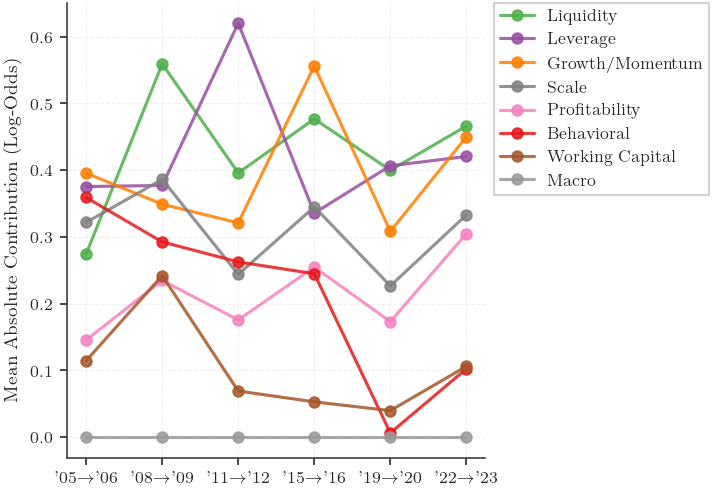

In [ ]:
# Feature Group Importance Evolution - Standalone Figure
fig, ax = plt.subplots(figsize=FIGSIZE['standalone'])
available_periods = list(period_data.keys())

group_colors = {
    'Behavioral': '#e41a1c',
    'Scale_Industry': '#377eb8',
    'Liquidity': '#4daf4a',
    'Leverage': '#984ea3',
    'Growth_Momentum': '#ff7f00',
    'Profitability': '#f781bf',
    'Working_Capital': '#a65628',
    'Macro': '#999999',
}

# Cleaner group names for legend
group_display_names = {
    'Scale_Industry': 'Scale/Industry',
    'Growth_Momentum': 'Growth/Momentum',
    'Working_Capital': 'Working Capital',
}

x_positions = np.arange(len(available_periods))

# Period display labels - updated for single-year training
period_display_map = {
    'pre_crisis': "'05$\\to$'06",
    'financial_crisis': "'08$\\to$'09",
    'sovereign_debt': "'11$\\to$'12",
    'recovery': "'15$\\to$'16",
    'covid': "'19$\\to$'20",
    'post_covid': "'22$\\to$'23"
}

for group_name in grouped_importance.index:
    values = grouped_importance.loc[group_name, available_periods].values
    display_name = group_display_names.get(group_name, group_name)
    ax.plot(x_positions, values, 
            marker='o', linewidth=1.5, markersize=5,
            label=display_name, color=group_colors.get(group_name, 'gray'),
            alpha=0.85)

ax.set_xticks(x_positions)
ax.set_xticklabels([period_display_map[p] for p in available_periods])
ax.set_ylabel(r'Mean Absolute Contribution (Log-Odds)')
ax.set_xlabel('')
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, frameon=True)
despine(ax)

plt.tight_layout()
save_figure(fig, FIGURES_DIR / 'temporal_group_importance_oneyear.pdf')
plt.show()

### 6.1 Detailed Temporal Pattern Analysis

Let's examine specific patterns more closely to understand the economic intuition behind the importance shifts.

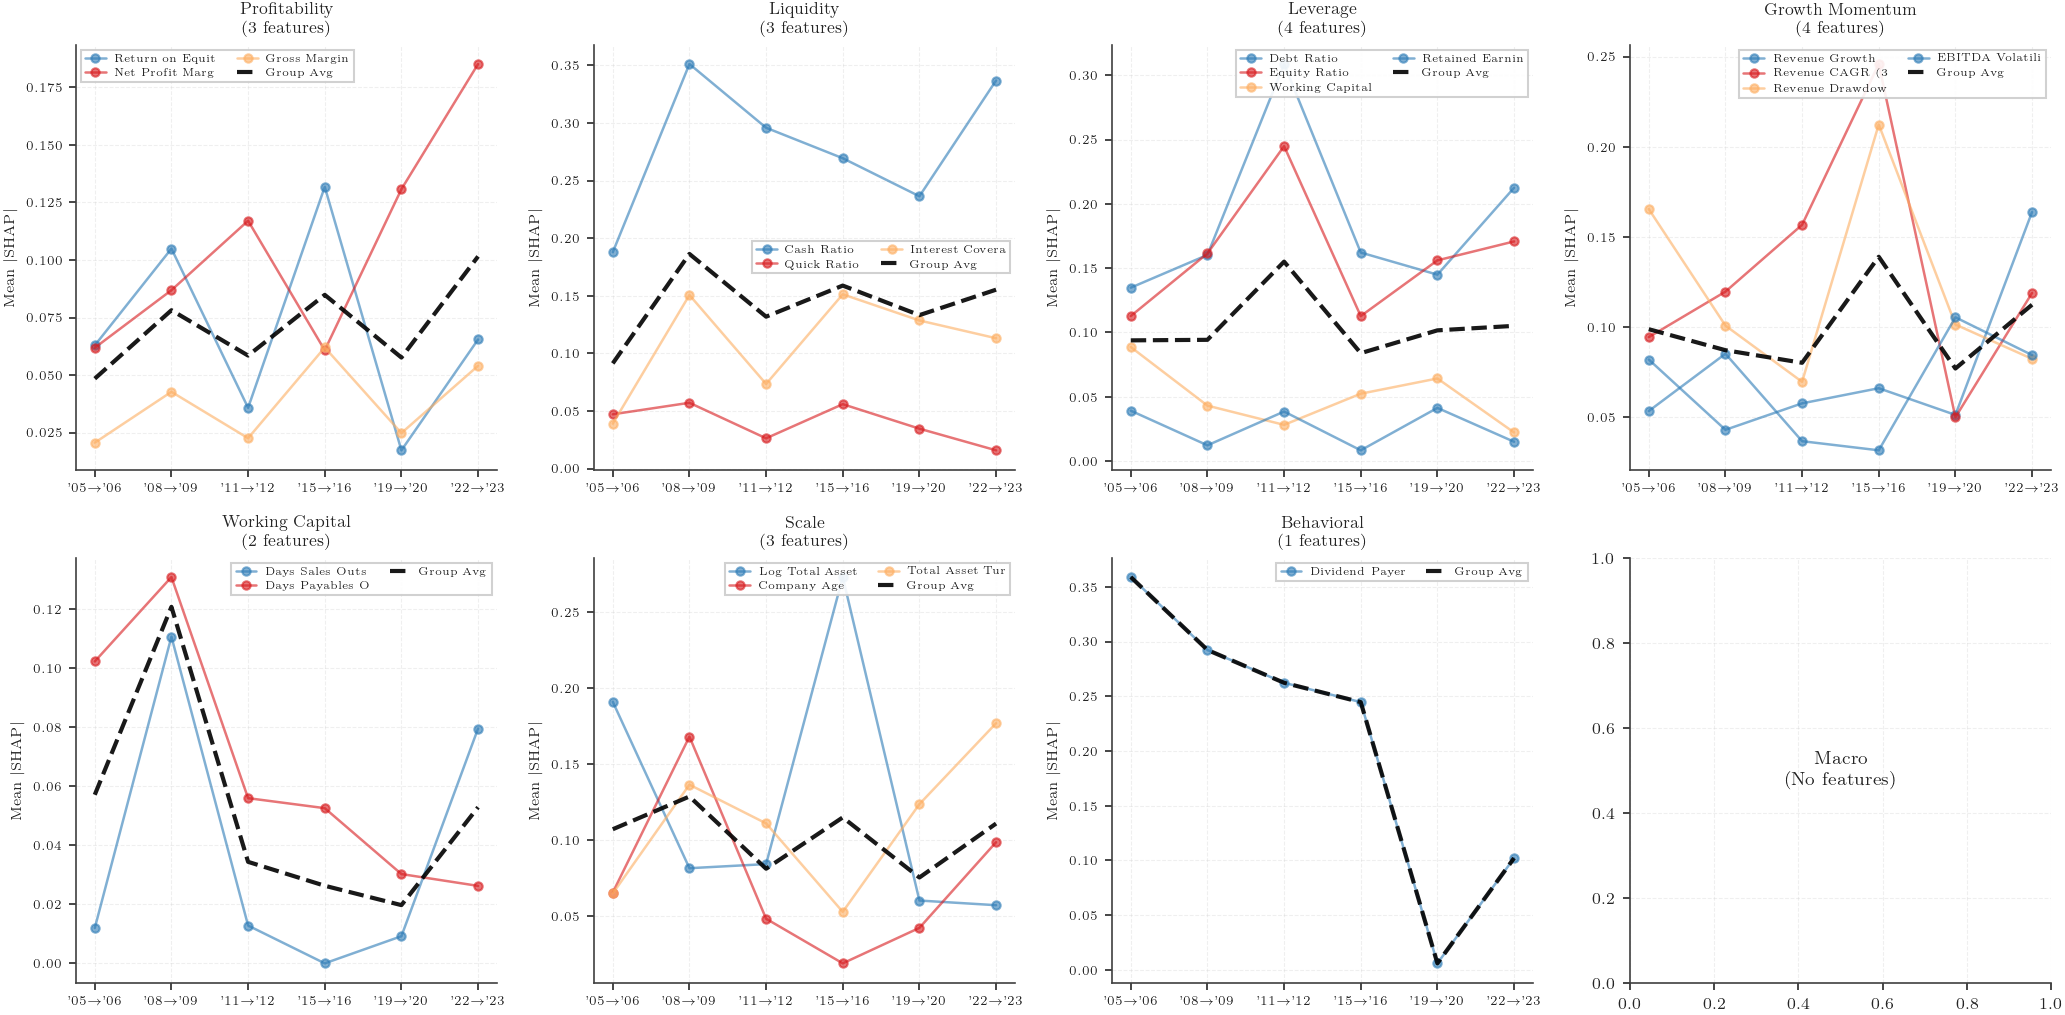

In [16]:
# Detailed Temporal Pattern Analysis by Feature Group
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()
available_periods = list(period_data.keys())

# Updated period labels for single-year training
period_labels = {
    'pre_crisis': "'05$\\to$'06",
    'financial_crisis': "'08$\\to$'09",
    'sovereign_debt': "'11$\\to$'12",
    'recovery': "'15$\\to$'16",
    'covid': "'19$\\to$'20",
    'post_covid': "'22$\\to$'23"
}

for idx, (group_name, features) in enumerate(FEATURE_GROUPS.items()):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    valid_features = [f for f in features if f in importance_evolution.index]
    
    if not valid_features:
        ax.text(0.5, 0.5, f'{group_name}\n(No features)', ha='center', va='center')
        continue
    
    for feature in valid_features:
        display_name = get_display_name(feature)
        values = importance_evolution.loc[feature, available_periods].values
        ax.plot(range(len(available_periods)), values, 
                marker='o', linewidth=1.2, markersize=4,
                label=display_name[:15], alpha=0.6)
    
    # Group average (bold)
    group_avg = importance_evolution.loc[valid_features, available_periods].mean(axis=0)
    ax.plot(range(len(available_periods)), group_avg.values, 
            linewidth=2, color='black', linestyle='--',
            label='Group Avg', alpha=0.9)
    
    ax.set_xticks(range(len(available_periods)))
    ax.set_xticklabels([period_labels[p] for p in available_periods], fontsize=6)
    ax.set_ylabel(r'Mean $|\mathrm{SHAP}|$', fontsize=7)
    
    # Clean group name for title
    clean_name = group_name.replace('_', ' ')
    ax.set_title(f'{clean_name}\n({len(valid_features)} features)', fontsize=8, fontweight='bold')
    ax.tick_params(labelsize=6)
    ax.legend(fontsize=5, loc='best', ncol=2)
    despine(ax)

for idx in range(len(FEATURE_GROUPS), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

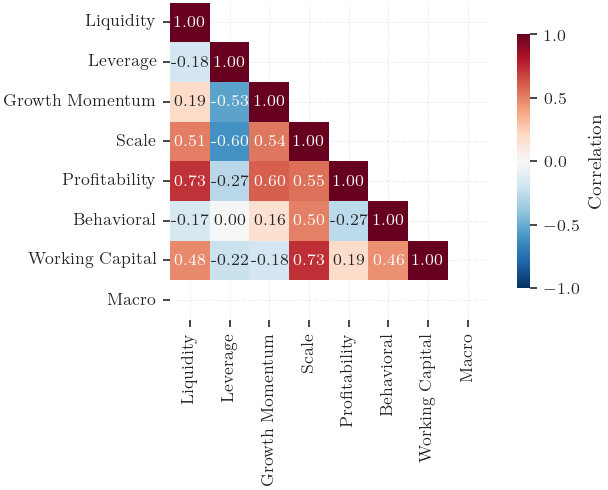

In [ ]:
# Temporal Correlation Between Feature Groups
available_periods = list(period_data.keys())
group_temporal_corr = grouped_importance[available_periods].T.corr()

fig, ax = plt.subplots(figsize=FIGSIZE['standalone'])

# Lower triangle mask
mask = np.triu(np.ones_like(group_temporal_corr, dtype=bool), k=1)

# Clean group names for display
clean_names = [n.replace('_', ' ') for n in group_temporal_corr.index]

sns.heatmap(group_temporal_corr, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, ax=ax,
            mask=mask, square=True,
            vmin=-1, vmax=1,
            annot_kws={'size': 8},
            xticklabels=clean_names,
            yticklabels=clean_names,
            cbar_kws={'label': 'Correlation', 'shrink': 0.8})

ax.tick_params(labelsize=8)

plt.tight_layout()
save_figure(fig, FIGURES_DIR / 'temporal_group_correlation_oneyear.pdf')
plt.show()

## 7. Cache Results for Future Analysis

In [ ]:
results_dir = PROJ_ROOT / "results" / "xai_temporal"
results_dir.mkdir(parents=True, exist_ok=True)

importance_evolution.to_csv(results_dir / "importance_evolution_oneyear.csv")
grouped_importance.to_csv(results_dir / "grouped_importance_evolution_oneyear.csv")
performance_comparison.to_csv(results_dir / "performance_by_period_oneyear.csv", index=False)

cache_file = results_dir / "temporal_cache_oneyear.pkl"
with open(cache_file, 'wb') as f:
    pickle.dump({
        'period_models': period_models,
        'period_predictions': period_predictions,
        'period_shap': period_shap,
        'ale_evolution': ale_evolution,
        'importance_evolution': importance_evolution,
        'grouped_importance': grouped_importance,
    }, f)